In [1]:
#default_exp self_supervised

In [2]:
#export
from rsna_retro.imports import *
from rsna_retro.metadata import *
from rsna_retro.preprocess import *
from rsna_retro.train import *
from rsna_retro.contrastive_loss import *

Loading imports


In [3]:
torch.cuda.set_device(0)

## Vanila Dataset

In [4]:
#export
def get_ss_gen(fns, bs, img_tfm, splits, nw=8, test=False):
    tfms = [[img_tfm, ToTensor], [fn2label,EncodedMultiCategorize(htypes)]]
    if test: tfms = [tfms[0]]
    dsets = Datasets(fns, tfms, splits=splits)
    batch_tfms = L(IntToFloatTensor)
    return dsets.dataloaders(bs=bs, num_workers=nw, after_batch=batch_tfms)

In [5]:
#export
def get_ss_data(bs, splits, img_dir=path_jpg256, **kwargs):
    return get_ss_gen(L(list(Meta.df_comb.index)), bs=bs, img_tfm=get_pil_fn(path/img_dir), 
                      splits=splits, **kwargs)

In [6]:
dls = get_ss_data(32, splits=Meta.splits_sample)

In [8]:
# dls.show_batch()

In [9]:
xb,yb = dls.one_batch(); xb.shape

torch.Size([32, 3, 256, 256])

In [10]:
#export
def pipe_update_size(pipe, size):
    for tf in pipe.fs:
        if isinstance(tf, RandomResizedCropGPU):
            tf.size = size

In [ ]:
#export
def get_aug_pipe(size, min_scale=0.4, stats=(mean,std), **kwargs):
    tfms = [Normalize.from_stats(*stats)] + aug_transforms(size=size, min_scale=min_scale, **kwargs)
    return Pipeline(tfms)

In [12]:
p = get_aug_pipe(size=128)
p(xb).shape

torch.Size([32, 3, 128, 128])

In [13]:
p

Pipeline: AffineCoordTfm -> RandomResizedCropGPU -> LightingTfm -> Normalize

In [14]:
pipe_update_size(p, 384)
p(xb).shape

torch.Size([32, 3, 384, 384])

## Sanity Checking Triple loss

In [15]:
xb,yb = dls.one_batch()

In [16]:
aug = get_aug_pipe(256)

In [17]:
idx=0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


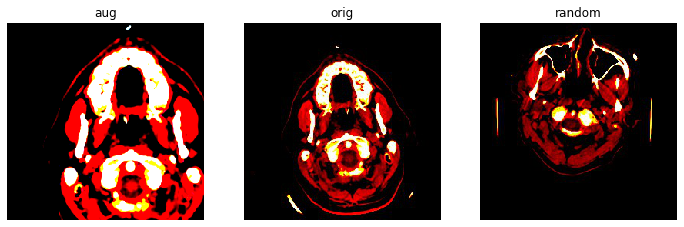

In [18]:
show_images([aug(xb)[0], xb[0], xb.flip(dims=[0])[0]], titles=['aug', 'orig', 'random'])

## Callbacks

In [19]:
#export
class SSModel(nn.Sequential):
    def __init__(self, model:nn.Sequential, num_feat=64, concat_pool=False, **kwargs): 
        super().__init__(*model)
        
        nf = num_features_model(self[0])
        head = create_head(nf, n_out, lin_ftrs, ps=ps, concat_pool=False, bn_final=bn_final)
        
        self.head = create_head(self)
        
    def features(self, x):
        return super().forward(x)
#         return self[1][:2](self[0](x))
    
    def logits(self, x):
        return x
#         return self[1][2:](x)
        
    def forward(self, *args):
        feats = [self.features(x) for x in args]
        logits = [self.logits(x) for x in feats]
        return tuple(feats), tuple(logits)

In [20]:
anchor = torch.randn(2,2).requires_grad_().cuda() # bs x features

In [21]:
#export
class CombinedSSLoss(nn.Module):
    def __init__(self, ss_loss_func, orig_loss_func, multi_loss=False):
        super().__init__()
        store_attr(self, 'ss_loss_func,orig_loss_func,multi_loss')
        
    def ss_loss(self, preds, labels): 
        (anchor, positive), _ = preds
        return self.ss_loss_func(anchor, positive)
    
    def orig_loss(self, preds, labels):
        _, (logits_targ, _) = preds
        return self.orig_loss_func(logits_targ, labels)
        
    def forward(self, preds, labels):
        if not self.multi_loss: return self.ss_loss(preds, labels)
        return self.ss_loss(preds, labels) + self.orig_loss(preds, labels)

In [22]:
#export
from functools import wraps
def wrap_metric(f):
    @wraps(f)
    def wrapped_f(preds, targ):
        _, (inp, _) = preds
        return f(inp, targ)
    return wrapped_f

In [23]:
#export
class SSCallback(Callback):
    run_before=Recorder
    def __init__(self, loss_func, size=256, aug_targ=None, aug_pos=None, multi_loss=False):
        self.aug_targ = ifnone(aug_targ, get_aug_pipe(size, min_scale=0.7))
        self.aug_pos = ifnone(aug_pos, get_aug_pipe(size, min_scale=0.4))
        self.ss_loss_func = loss_func
        self.multi_loss = multi_loss
        self.orig_metrics = None
        
    def update_size(self, size):
        pipe_update_size(self.aug_targ, size)
        pipe_update_size(self.aug_pos, size)
        
    def begin_fit(self): 
        self.learn.model = SSModel(self.learn.model)
        
        
        lf = CombinedSSLoss(self.ss_loss_func, self.learn.loss_func, self.multi_loss)
        self.learn.loss_func = lf
        self.orig_metrics = self.learn.metrics
        
        self.learn.metrics = [wrap_metric(f.func) for f in self.orig_metrics]
        self.learn.dls.valid.shuffle = True # prevents high loss if images ordered by class
        if self.multi_loss:
            self.learn.metrics += [lf.ss_loss, lf.orig_loss]
            
    def after_fit(self): 
        self.learn.model = nn.Sequential(*self.learn.model)
        self.learn.loss_func = self.learn.loss_func.orig_loss_func
        self.learn.metrics = self.orig_metrics
        self.learn.dls.valid.shuffle = False
        
    def set_split(self, split_idx):
        self.aug_targ.split_idx = split_idx
#         self.aug_pos.split_idx = split_idx # always keep augmentation
    def begin_validate(self): self.set_split(1)
    def begin_train(self): self.set_split(0)
        
    def begin_batch(self):
        xb, = self.learn.xb
        xb_targ = self.aug_targ(xb)
        xb_pos = self.aug_pos(xb)
        self.learn.xb = xb_targ, xb_pos
        

## Training

In [24]:
# size=128
# dls = get_ss_data(128, splits=Meta.splits_sample)
# cb = SSCallback(TripletLoss())
# learn = cnn_learner(dls, xresnet18, loss_func=get_loss(), lr=3e-3,
#             opt_func=Adam, metrics=[], cbs=cb)


# learn.fit_one_cycle(1)

## Training

In [25]:
size=128
dls = get_ss_data(128, splits=Meta.splits_sample)
cb = SSCallback(XentLoss(0.1))

ch = nn.Sequential(nn.AdaptiveAvgPool2d(1), Flatten(), nn.Linear(512, 20))
learn = cnn_learner(dls, xresnet18, loss_func=get_loss(), lr=3e-3,
                    opt_func=Adam, metrics=[accuracy_any], cbs=cb,
                    config={'custom_head':ch}
                   )


In [ ]:
learn.fit_one_cycle(2)

epoch,train_loss,valid_loss,accuracy_any,time


Exception ignored in: <function _releaseLock at 0x7fc17a6a5560>
Traceback (most recent call last):
  File "/home/ashaw/anaconda3/envs/rsna_retro/lib/python3.7/logging/__init__.py", line 221, in _releaseLock
    def _releaseLock():
KeyboardInterrupt


In [ ]:
learn.model[1][:2]

In [ ]:
learn.model[1][2:]

## Train Contrastive + Labels

In [23]:
size=128
dls = get_ss_data(128, splits=Meta.splits_sample)
cb = SSCallback(BatchContrastiveLoss(ContrastiveLoss()), multi_loss=True)
learn = cnn_learner(dls, xresnet18, loss_func=get_loss(), lr=3e-3,
            opt_func=Adam, metrics=[], cbs=cb)


In [24]:
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,accuracy_ss,ss_loss,orig_loss,time
0,1.692516,8.418243,0.745368,7.972192,0.446051,00:35


## Export

In [1]:
#hide
from nbdev.export import notebook2script
notebook2script()

Converted 00_metadata.ipynb.
Converted 01_preprocess.ipynb.
Converted 01_preprocess_mean_std.ipynb.
Converted 02_train.ipynb.
Converted 02_train_01_save_features.ipynb.
Converted 03_train3d.ipynb.
Converted 04_trainfull3d_deprecated.ipynb.
Converted 04_trainfull3d_labels.ipynb.
Converted 05_train_adjacent.ipynb.
Converted 06_seutao_features.ipynb.
Converted 07_adni.ipynb.
This cell doesn't have an export destination and was ignored:
e
This cell doesn't have an export destination and was ignored:
#
This cell doesn't have an export destination and was ignored:
e
Converted 07_adni_01.ipynb.
Converted 08_contrastive_loss-Copy1.ipynb.
Converted 08_contrastive_loss.ipynb.
Converted 08_imagewang.ipynb.
Converted 08_train_self_supervised.ipynb.
Converted 08_train_self_supervised_train_1.ipynb.
Converted 08_train_self_supervised_train_2_nocombined.ipynb.
Converted 08_train_self_supervised_train_2_nocombined_contrast.ipynb.
Converted 08_train_self_supervised_train_3.ipynb.
Converted 08_train_sel